# Traffic Sign Recogntion with TensorFlow Deep Learning,  
# Waleed Abdulla 22/05/2017

Vamos a transcribir la conferencia de Waleed Abdulla en el San Francisco Bay ACM.  
https://www.youtube.com/watch?v=QHra6Xf6Mew&t=2268s  
Se hace una pequeña introducción de un modelo con una única capa totalmente conectada de 62 nodos.  
Lego se ejecuta una estrucutra de multi capas con redes convolucionales para alacanzar el nivel humano.

In [1]:
import os
import random
import skimage.data
import skimage.transform
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
import pandas as pd
import csv
import math

# Allow image embeding in notebook
%matplotlib inline

## Model 1: One Fully-Connected Layer - Accuracy: 60-70%  
To have a base to build on, here is a copy of code from part 1. refactored and simplified to keep just the parts we care about here.  

Notice that, unlike the code in Part 1, here I build the model in a classa and start the session inmediaately after building the model. This allows me do something like my_model=Model1() and get a fully built model with a valid graph and session objects right away

In [2]:
class Model1():
    #***BASIC MODEL WITH 1 FC LAYER***
    def __init__(self):
        self.graph = tf.Graph()
        with self.graph.as_default():
            #Placeholders
            self.images=tf.placeholder(tf.float32,(None,32, 32,3), name='images')
            self.labels=tf.placeholder(tf.int32, [None], name='labels')
            #Flatten input
            self.images_flat=tf.contrib.layers.flatten(self.images)
            #Fully connected layer
            self.logits=tf.contrib.layers.fully_connected(self.images_flat,62, tf.nn.relu)
            #Convert one hot vector to label indexes (int)
            self.predicted_labels=tf.argmax(self.logits,1)
            #Loss
            self.loss = tf.reduce_mean(tf.nn.sparse_softmax_cross_entropy_with_logits(
                    logits=self.logits, labels=self.labels))
            #Training
            self.train=tf.train.AdamOptimizer(learning_rate=0.001).minimize(self.loss)
            #Initialization
            self.init=tf.global_variables_initializer()
            #Create session
            self.session=tf.Session()
            #Run Initialization
            self.session.run(self.init)
        

### Load Training and Test Data  
This is straightforward, the load() function traverses the dataset directories and loads the images and labels. Since this dataset is small, I load the whole thing into RAM to keep things simple.

In [3]:
def load_data(data_dir, width, height):
    directories = [d for d in os.listdir(data_dir) 
                 if os.path.isdir(os.path.join(data_dir, d))]

    labels = []
    images = []
    for d in directories:
        label_dir = os.path.join(data_dir, d)
        file_names = [os.path.join(label_dir, f) 
                      for f in os.listdir(label_dir) if f.endswith(".ppm")]
        for f in file_names:
            labels.append(int(d))
            images.append(skimage.transform.resize(skimage.data.imread(f), (width, height)))
    
    labels=np.array(labels)
    images=np.array(images)
    
    return images, labels

In [4]:
train_data_dir = ".\\data\\Training"            
X_train_orig, Y_train_orig = load_data(train_data_dir,32,32)

D:\ANACONDA\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "


In [5]:
test_data_dir = ".\\data\\Testing" 
X_test_orig, Y_test_orig = load_data(test_data_dir,32,32)

D:\ANACONDA\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "


### Visualizing the dataset

In [6]:
def display_images_and_labels(images,labels):
    unique_labels = set(labels)
    plt.figure(figsize=(15, 15))
    i = 1
    for label in unique_labels:
        #When working with Python Lists
        #image = images[labels.index(label)]
        #When working with numpys
        image = images[labels.tolist().index(label)]
        plt.subplot(8, 8, i)
        plt.axis('off')
        #plt.title("Label {0} ({1})".format(label, labels.count(label)))
        plt.title("Label {0}".format(label))
        i += 1
        _ = plt.imshow(image)
    
    plt.show()

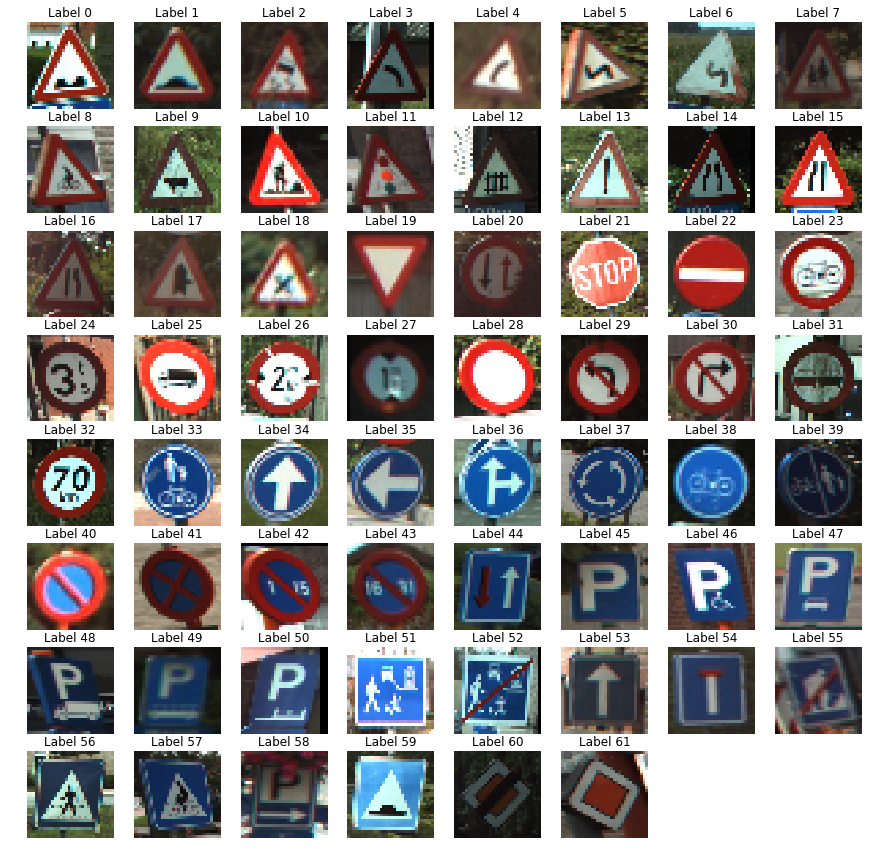

In [7]:
display_images_and_labels(X_train_orig,Y_train_orig)

In [8]:
print('Las 5 primeras imágenes modificadas tienen los siguientes valores max y min de RGB: ')
i=1
for image in X_train_orig[:5]:
    print('Valor max de la imagen',i, image.max())
    print('Valor min de la imagen',i, image.min())
    i+=i

Las 5 primeras imágenes modificadas tienen los siguientes valores max y min de RGB: 
Valor max de la imagen 1 1.0
Valor min de la imagen 1 0.0073912377450982
Valor max de la imagen 2 1.0
Valor min de la imagen 2 0.003576899509804572
Valor max de la imagen 4 1.0
Valor min de la imagen 4 0.0015567555147058805
Valor max de la imagen 8 0.969267003676469
Valor min de la imagen 8 0.056774662990195915
Valor max de la imagen 16 0.9895220588235292
Valor min de la imagen 16 0.026654411764708223


Los valores ya están normalizados.  
Parece que W.A normaliza otra vez las imagenes en su código.

In [9]:
def normalize(image):
    return (image-image.min())/(image.max()-image.min())

def display_images(images, titles=None, cols=5, interpolation=None):
    """ 
    images: A list of images. It can be either:
        + A list of Numpy arrays. Each array represents an image.
        + A list of lists of numpy arrays. In this casse, the images in the inner
          the inner lists are concatentated to make one image.
    
    """
    
    titles = titles or [""] * len(images)
    rows = math.ceil(len(images)/(cols))
    height_ratio =1.2*(rows/cols)*(0.5 if type(images[0]) is not np.ndarray else 1)
    plt.figure(figsize=(11,11 * height_ratio))
    i=1
    for image, title in zip(images, titles):
        plt.subplot(rows, cols, i)
        plt.axis("off")
        if type(image) is not np.ndarray:
            image = [normalize(g) for g in image]
            image = np.concatenate(image, axis=1)
        else:
            image = normalize(image)
        plt.title(title, fontsize = 9)
        plt.imshow(image, cmap="Greys_r", interpolation=interpolation)
        i += 1

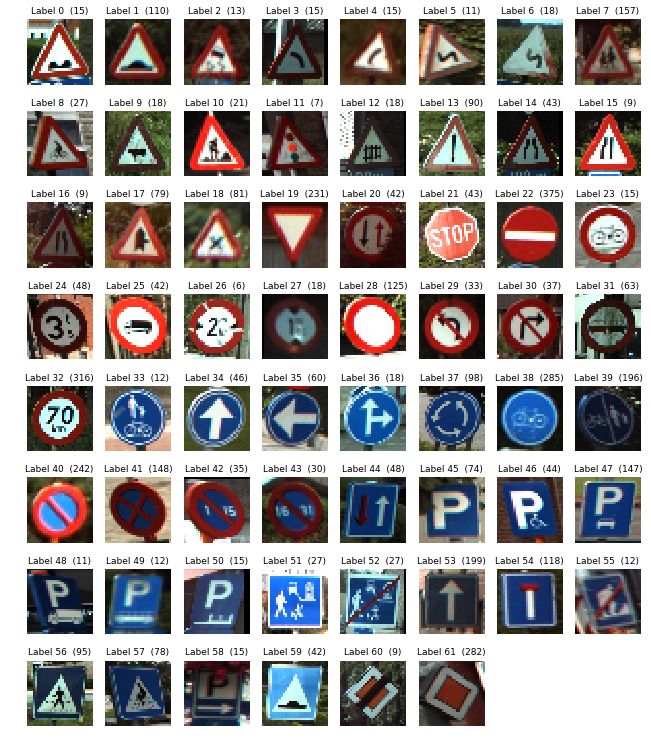

In [10]:
#label_exemplars= [X_train_orig[np.where(Y_train_orig == l)][:][:] for l in range(62)]
label_exemplars =[]
for i in range(62):
    for w in range(len(Y_train_orig)):
        if Y_train_orig[w] == i:
            label_exemplars.append(X_train_orig[w])
            break
#label_counts = [np.count_nonzero(X_train_orig ==l ) for l in range(62)]
label_counts = []
for i in range(62):
    label_counts.append(0)
    for w in range(len(Y_train_orig)):
        if Y_train_orig[w] == i:
            label_counts[i] = label_counts[i]+1

titles= ["Label {}  ({})".format(l,c) for l, c in enumerate(label_counts)]
display_images(label_exemplars, titles, cols=8)

### Training and Evaluation

I refactored the previous training and evaluation code into two fuctions here. And I also set it such that the evaluation on teh test set is done preiodically throughout the training. This way, if the model starts to overfit we can spot the right away but noticing that the accuracy on the test set starts dropping while the accuracy on the training set continuin to improve.

In [11]:
def train(model, images, labels, test_images, test_labels, train_count, imprimir=True):
    #Training loop
    for i in range(train_count):
        if i % 20 == 0:
            evaluate(model, test_images, test_labels, i, imprimir)
        model.session.run(model.train,{
            model.images:images,
            model.labels:labels})
    #Final evaluation
    evaluate(model, test_images, test_labels,i)


#TODO: evaluate training loss and accuracy

def evaluate(model, images, labels, step, imprimir=True):
    #Run predictions against the full test set
    predicted, loss = model.session.run([model.predicted_labels, model.loss],
                                       {model.images: images, model.labels:labels})
    #Calculate accuracy and print
    accuracy=np.sum(labels == predicted)/labels.shape[0]
    if imprimir == True:
        print("{:4}, Loss: {:.3f}  Test accuracy: {:.3f}".format(step,loss, accuracy))

In [12]:
m1 = Model1()
train(m1, X_train_orig, Y_train_orig, X_test_orig, Y_test_orig, 200 , imprimir=True)

D:\ANACONDA\envs\tensorflow\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


   0, Loss: 4.186  Test accuracy: 0.002
  20, Loss: 2.483  Test accuracy: 0.515
  40, Loss: 2.096  Test accuracy: 0.647
  60, Loss: 1.946  Test accuracy: 0.672
  80, Loss: 1.846  Test accuracy: 0.682
 100, Loss: 1.775  Test accuracy: 0.689
 120, Loss: 1.722  Test accuracy: 0.692
 140, Loss: 1.680  Test accuracy: 0.695
 160, Loss: 1.646  Test accuracy: 0.697
 180, Loss: 1.619  Test accuracy: 0.700
 199, Loss: 1.596  Test accuracy: 0.700


La accuracy del model depende del mínimo o máximo local en el que caiga al inicializar.  
Vamos a probar que pasa si entrenamos el modelo 5 veces.

In [13]:
for i in range(5):
    m1 = Model1()
    train(m1, X_train_orig, Y_train_orig, X_test_orig, Y_test_orig, 200 , imprimir=False)

 199, Loss: 1.744  Test accuracy: 0.663
 199, Loss: 1.722  Test accuracy: 0.658
 199, Loss: 2.110  Test accuracy: 0.570
 199, Loss: 1.718  Test accuracy: 0.666
 199, Loss: 1.405  Test accuracy: 0.733


Como ya sabíamos varía mucho entre 60 y 70%

In [14]:
def train(model, images, labels, test_images, test_labels, train_count):
    #Training loop
    for i in range(train_count):
        if i % 20 == 0:
            evaluate(model, images, labels,test_images, test_labels, i)
        model.session.run(model.train,{
            model.images:images,
            model.labels:labels})
    #Final evaluation
    evaluate(model, images, labels,test_images, test_labels,i)


#TODO: evaluate training loss and accuracy

def evaluate(model, images, labels, test_images, test_labels, step):
    #Run predictions against the full test set
    predicted_train, loss_train = model.session.run([model.predicted_labels, model.loss],
                                       {model.images: images, model.labels:labels})
    predicted_test, loss_test = model.session.run([model.predicted_labels, model.loss],
                                       {model.images: test_images, model.labels:test_labels})
    #Calculate accuracy and print
    accuracy_train=np.sum(labels == predicted_train)/labels.shape[0]
    accuracy_test=np.sum(test_labels == predicted_test)/test_labels.shape[0]
    print("{:4}, Loss: {:.3f}  Train accuracy: {:.3f}".format(step,loss_train, accuracy_train))
    print("{:4}, Loss: {:.3f}  Test accuracy: {:.3f}".format(step ,loss_test, accuracy_test))

In [15]:
m1 = Model1()
train(m1, X_train_orig, Y_train_orig, X_test_orig, Y_test_orig, 200 )

   0, Loss: 4.239  Train accuracy: 0.005
   0, Loss: 4.243  Test accuracy: 0.006
  20, Loss: 2.609  Train accuracy: 0.528
  20, Loss: 2.679  Test accuracy: 0.487
  40, Loss: 2.280  Train accuracy: 0.571
  40, Loss: 2.375  Test accuracy: 0.550
  60, Loss: 2.135  Train accuracy: 0.585
  60, Loss: 2.232  Test accuracy: 0.569
  80, Loss: 2.050  Train accuracy: 0.590
  80, Loss: 2.151  Test accuracy: 0.577
 100, Loss: 1.992  Train accuracy: 0.593
 100, Loss: 2.095  Test accuracy: 0.583
 120, Loss: 1.949  Train accuracy: 0.595
 120, Loss: 2.054  Test accuracy: 0.586
 140, Loss: 1.915  Train accuracy: 0.597
 140, Loss: 2.024  Test accuracy: 0.588
 160, Loss: 1.888  Train accuracy: 0.597
 160, Loss: 2.000  Test accuracy: 0.589
 180, Loss: 1.866  Train accuracy: 0.598
 180, Loss: 1.981  Test accuracy: 0.588
 199, Loss: 1.847  Train accuracy: 0.599
 199, Loss: 1.966  Test accuracy: 0.589


He cambiado un poco el código para recalcar que hay dos tipos de "accuracy" la del "train_set" y la del "test_set"

 ### Looking inside the Trained Model

Visualizing what themodel has learned is a fun exercise, and it fives us insight into how the model works. Visualizing the weights of this model should be easy because hte weights have the same shape as the input images. Why? because each neuron connects to all the pixels of the input image, so we have a weight for each RGB value of each pixel. We can simply reshape the wights matrix into a 32x32x3 tensor and display them like images.  


To get the weight values, I need to pass the weight tensor objecto to Session.run(). The problem is : I dont't have a refrence to that object because I created the fully connected layer using fully_connected() wich does the work internally. Instead I'll print the names of all the trainable variables and then use the variable name to get it's value.

In [16]:
# Loop trough the graph and print the names and shapes of all trainable variables
with m1.graph.as_default():
    for v in tf.trainable_variables():
        print(v.name, v.get_shape())

fully_connected/weights:0 (3072, 62)
fully_connected/biases:0 (62,)


In [17]:
#Get the values of the weight and bias variables.
m1_weights=m1.session.run("fully_connected/weights:0")
m1_biases=m1.session.run("fully_connected/biases:0")
print("weights shape: {!s:10}    min: {:.4f}    max: {:.4f}".format(m1_weights.shape, m1_weights.min(), m1_weights.max()))
print("biases shape: {!s:10}    min: {:.4f}    max: {:.4f}".format(m1_biases.shape, m1_biases.min(), m1_biases.max()))

weights shape: (3072, 62)    min: -0.1652    max: 0.1815
biases shape: (62,)         min: -0.0484    max: 0.1582


The weights matrix is 3072x62. The 62 corresponds to the 62 neurons (wich correspond to the 62 labels), and teh 07 corresponds to the 32x32x3 input.

For clarify, I display an example of each label next to the values of it's corresponding weitghts.

In [18]:
def display_weights(weights, limit):
    titles= ["Label {}  ({})".format(l,c) for l, c in enumerate(label_counts)]
    images = list(zip(label_exemplars, weights.T.reshape(-1, 32, 32,3)))
    display_images(images[:limit], titles)

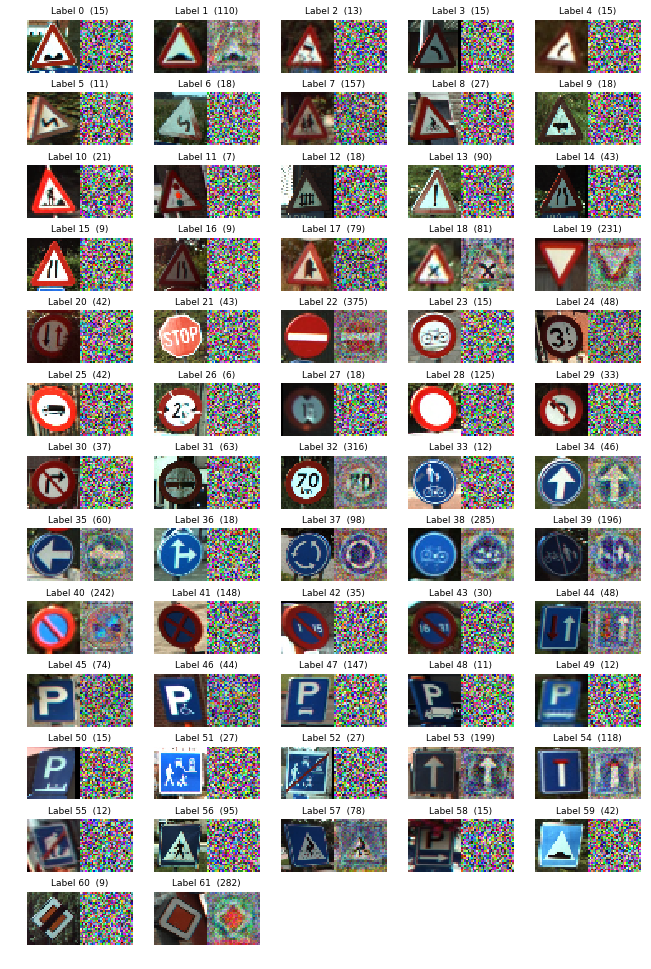

In [19]:
# Display weights of the first 30 labels
display_weights(m1_weights, 62)

Okay! Looks like many weights matricies are just random values. THe labels with more examples have weights that kind of resemble the corresponding examples, but labels with few examples have random weights.

To get more visibility into this, I'll visualize the histograms of the weights as well.

In [20]:
def display_histograms(weights, limit):
    plt.figure(figsize=(100,100))
    for i in range(limit):
        plt.subplot(25,3,i+1)
        w = weights[:,i]
        plt.title("Label {}".format(i), fontsize=8)
        plt.tick_params(labelsize=6)
        plt.yticks([])
        plt.xticks([w.min(),w.max()])
        plt.hist(w, bins=62)
    plt.tight_layout()

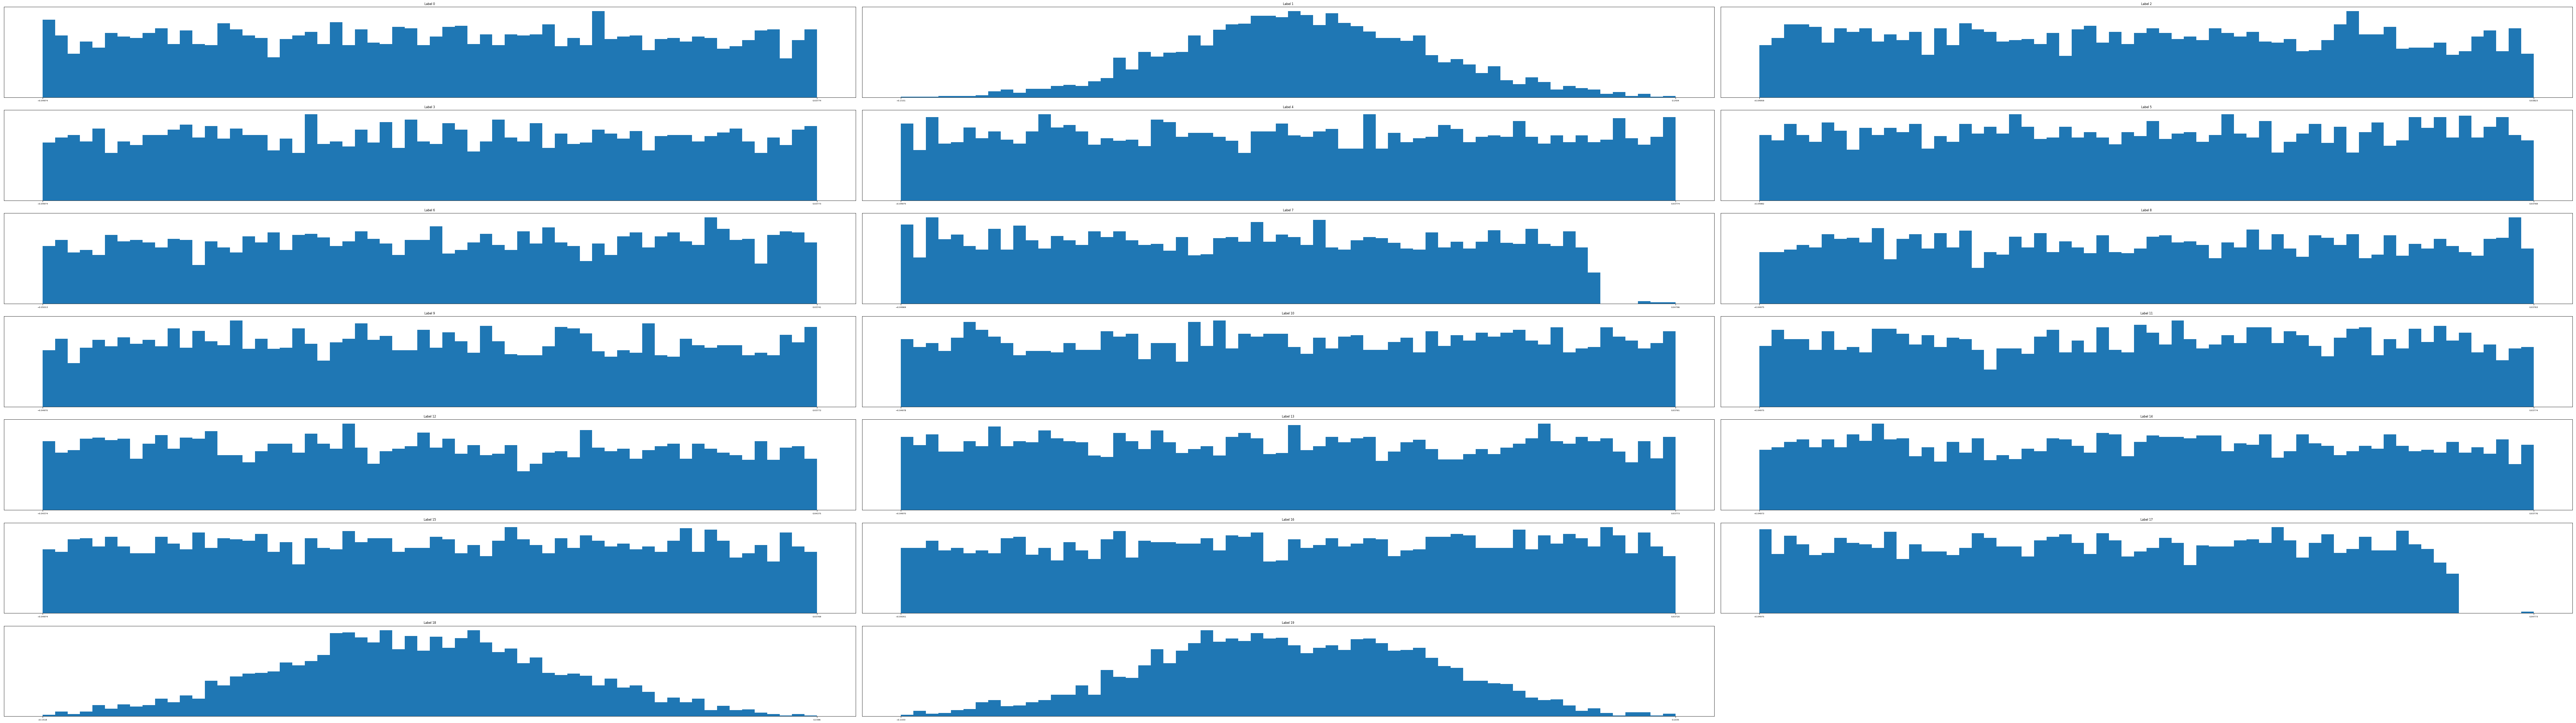

In [22]:
display_histograms(m1_weights, 20)

This confirms the previous finding. Some weight tensors have nice gaussian destributions and some are evenly distributed (wich is the how TensorFlow initilies all veriables by default).

## Model 2: Leaky-ReLU & Minibatches

It's clear that some weights in Model 1 were not trained at all. Model 2 will fix that by:
    + Replacing ReLU activations with Leaky ReLU,
    + Using mini-batches training rather than batch training

And where at it, I also replaced the step variable in the previous train() function with a global_step variabledefined in the model itself. This way, if I run the training function again, the step counter continues from where it had finished last.

In [23]:
# TensorFlow doesn't have a native implementation of Leaky-ReLU
# that I know of. But it's simple enough to add it.
def lrelu(x):
    return tf.maximum(0.01*x,x)

In [24]:
class Model2():

    def __init__(self):
        self.graph = tf.Graph()
        with self.graph.as_default():
            #Global setp counter
            self.global_step = tf.Variable(0, trainable=False,name='global_step')
            #Placeholders
            self.images=tf.placeholder(tf.float32,(None,32, 32,3), name='images')
            self.labels=tf.placeholder(tf.int32, [None], name='labels')
            #Flatten input
            self.images_flat=tf.contrib.layers.flatten(self.images)
            #Fully connected layer
            self.logits=tf.contrib.layers.fully_connected(self.images_flat,62, lrelu)
            #Convert one hot vector to label indexes (int)
            self.predicted_labels=tf.argmax(self.logits,1)
            #Loss
            self.loss = tf.reduce_mean(tf.nn.sparse_softmax_cross_entropy_with_logits(
                    logits=self.logits, labels=self.labels))
            #Training
            # Notice that we're passing the gloal_step variable as a parameter.
            # The minimize() function increments it with every training step.
            self.train=tf.train.AdamOptimizer(learning_rate=0.001)\
                        .minimize(self.loss, global_step=self.global_step)
            #Initialization
            self.init=tf.global_variables_initializer()
            #Create session
            self.session=tf.Session()
            #Run Initialization
            self.session.run(self.init)

In [25]:
def evaluate(model, images, labels, step, imprimir=True):
    #Run predictions against the full test set
    predicted, loss = model.session.run([model.predicted_labels, model.loss],
                                       {model.images: images, model.labels:labels})
    #Calculate accuracy and print
    accuracy=np.sum(labels == predicted)/labels.shape[0]
    if imprimir == True:
        print("{:4}, Loss: {:.3f}  Test accuracy: {:.3f}".format(step,loss, accuracy))
    

def train_minibatch(model, images, labels, test_images, test_labels, train_counts):
    #Training loop
    for i in range(train_counts):
        if i % 500 == 0:
            evaluate(model, test_images, test_labels, model.session.run(model.global_step))
        # ??? improve picking batches
        indexes = np.random.choice(np.arange(images.shape[0]), 50, replace=False)
        model.session.run(model.train,
                          {model.images: images[indexes],
                           model.labels: labels[indexes]})
    # Final evaluation
    evaluate(model, test_images, test_labels, model.session.run(model.global_step))

Ãll set! We can start training. Since each training step now has only 50 images rather than the full dataset, then we need to run a lot more training steps.

In [26]:
m2 = Model2()

In [27]:
train_minibatch(m2, X_train_orig, Y_train_orig, X_test_orig, Y_test_orig, 300)

   0, Loss: 4.234  Test accuracy: 0.012
 300, Loss: 1.092  Test accuracy: 0.785


### Visualize the weights

Same as above. Let's see if the changes had any effect.

In [28]:
# Loop trough the graph and print the names and shapes of all trainable variables
with m2.graph.as_default():
    for v in tf.trainable_variables():
        print(v.name, v.get_shape())

fully_connected/weights:0 (3072, 62)
fully_connected/biases:0 (62,)


In [29]:
m2_weights = m2.session.run("fully_connected/weights:0")
m2_biases = m2.session.run("fully_connected/biases:0")
print("weights shape: {!s:10}    min: {:.4f}    max: {:.4f}".format(m1_weights.shape, m1_weights.min(), m1_weights.max()))
print("biases shape: {!s:10}    min: {:.4f}    max: {:.4f}".format(m1_biases.shape, m1_biases.min(), m1_biases.max()))

weights shape: (3072, 62)    min: -0.1652    max: 0.1815
biases shape: (62,)         min: -0.0484    max: 0.1582


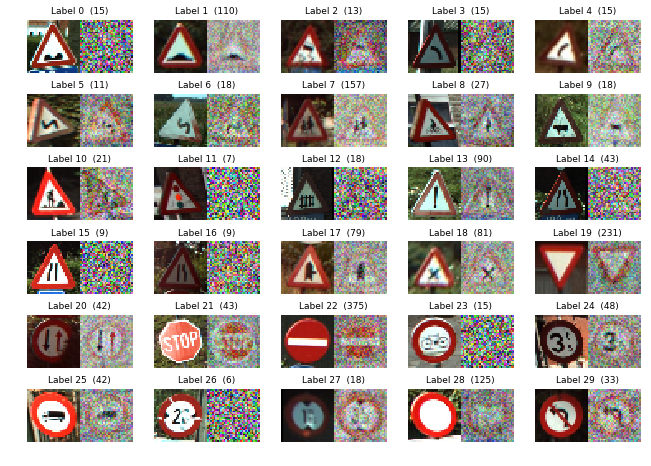

In [30]:
# Visualize weights of first 30 labels
display_weights(m2_weights, 30)

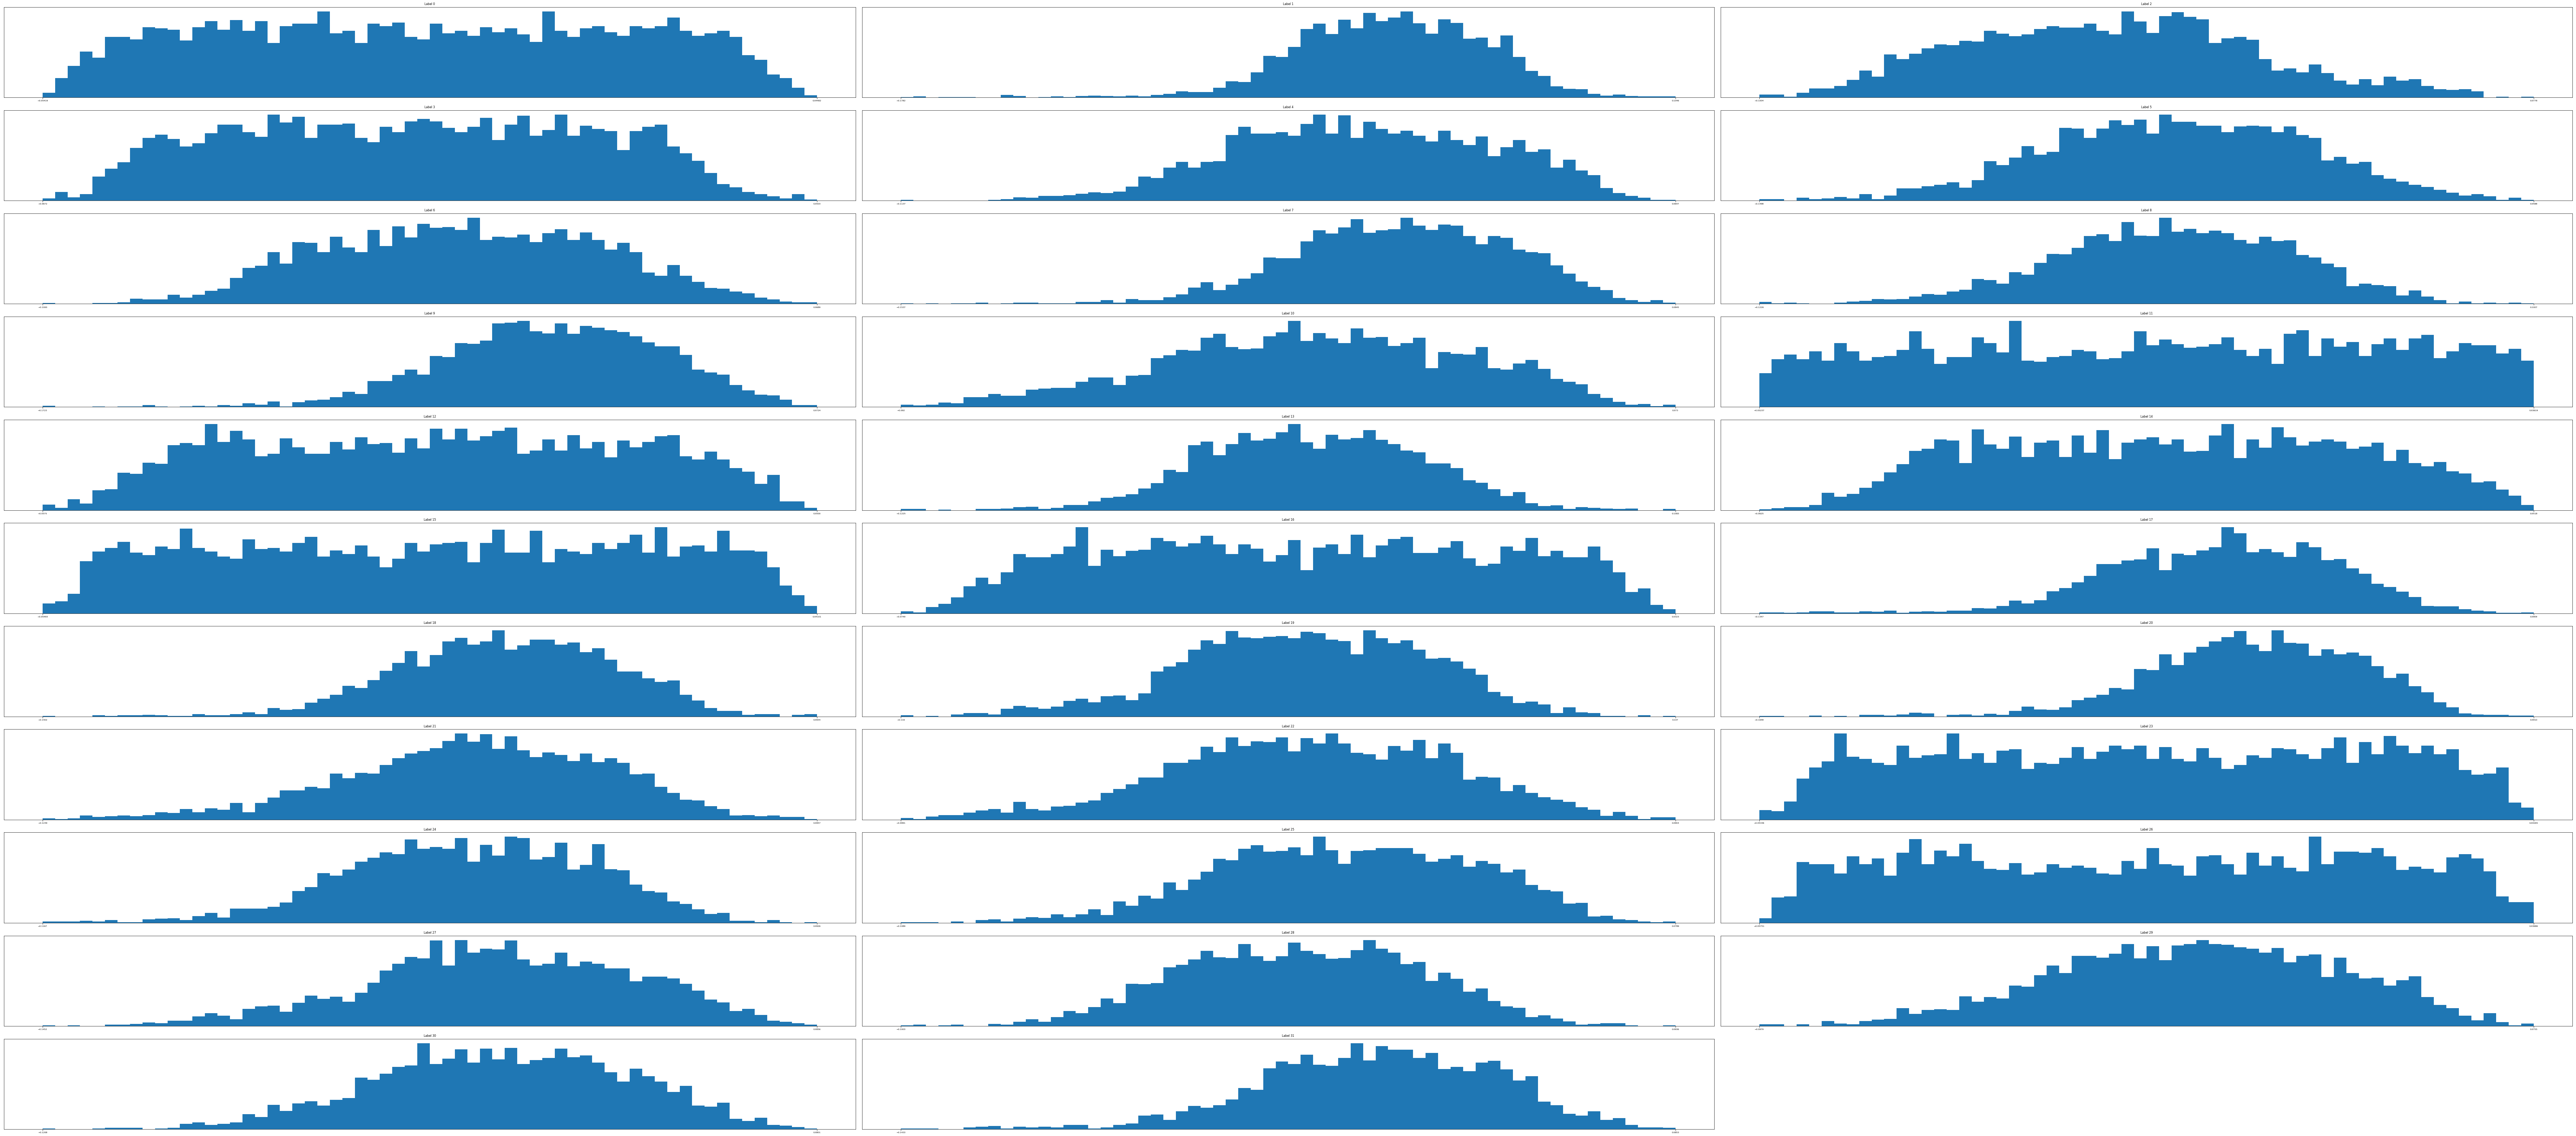

In [31]:
display_histograms(m2_weights,32)

Thats's much better. Model2 seems to have good looking weight images and histograms, and the accuracy went up significantly.

## Model 3: Going Deeper

In [32]:
class Model3():

    def __init__(self):
        self.graph = tf.Graph()
        with self.graph.as_default():
            #Global setp counter
            self.global_step = tf.Variable(0, trainable=False,name='global_step')
            #Placeholders
            self.images=tf.placeholder(tf.float32,(None,32, 32,3), name='images')
            self.labels=tf.placeholder(tf.int32, [None], name='labels')
            #Flatten input
            self.images_flat=tf.contrib.layers.flatten(self.images)
            #Fully connected layer
            self.h1=tf.contrib.layers.fully_connected(self.images_flat,200, lrelu)
            self.h2=tf.contrib.layers.fully_connected(self.h1,100, lrelu)
            self.logits=tf.contrib.layers.fully_connected(self.h2,62, lrelu)
            #Convert one hot vector to label indexes (int)
            self.predicted_labels=tf.argmax(self.logits,1)
            #Loss
            self.loss = tf.reduce_mean(tf.nn.sparse_softmax_cross_entropy_with_logits(
                    logits=self.logits, labels=self.labels))
            #Training
            # Notice that we're passing the gloal_step variable as a parameter.
            # The minimize() function increments it with every training step.
            self.train=tf.train.AdamOptimizer(learning_rate=0.001)\
                        .minimize(self.loss, global_step=self.global_step)
            #Initialization
            self.init=tf.global_variables_initializer()
            #Create session
            self.session=tf.Session()
            #Run Initialization
            self.session.run(self.init)

In [33]:
m3=Model3()

In [34]:
train_minibatch(m3, X_train_orig, Y_train_orig, X_test_orig, Y_test_orig, 7000)

   0, Loss: 4.243  Test accuracy: 0.003
 500, Loss: 0.696  Test accuracy: 0.833
1000, Loss: 0.628  Test accuracy: 0.837
1500, Loss: 0.468  Test accuracy: 0.884
2000, Loss: 0.392  Test accuracy: 0.910
2500, Loss: 0.408  Test accuracy: 0.907
3000, Loss: 0.851  Test accuracy: 0.809
3500, Loss: 0.363  Test accuracy: 0.924
4000, Loss: 0.364  Test accuracy: 0.927
4500, Loss: 0.499  Test accuracy: 0.892
5000, Loss: 0.510  Test accuracy: 0.894
5500, Loss: 0.640  Test accuracy: 0.879
6000, Loss: 0.388  Test accuracy: 0.934
6500, Loss: 0.412  Test accuracy: 0.930
7000, Loss: 0.409  Test accuracy: 0.932


### Visualize the Weights

Now that the model has 3 layers, visualizing it's weights is not as straghtforward as before. The fist layer is still a fully connected layer and it's nodes connect to every pixel in the input image, so we can visualize it like before. However, this time, the first layer works tith the second and third layers to arrive at a final classification, so the weights in the first layer don't represent the full picture. But let's try it anyway, and see what we get.

In [35]:
# Print the names of trainable variables.
with m3.graph.as_default():
    for v in tf.trainable_variables():
        print(v.name, v.get_shape())

fully_connected/weights:0 (3072, 200)
fully_connected/biases:0 (200,)
fully_connected_1/weights:0 (200, 100)
fully_connected_1/biases:0 (100,)
fully_connected_2/weights:0 (100, 62)
fully_connected_2/biases:0 (62,)


In [36]:
m3_w0 = m3.session.run("fully_connected/weights:0")
m3_w1 = m3.session.run("fully_connected_1/weights:0")
m3_w2 = m3.session.run("fully_connected_2/weights:0")
print("weights0 shape: {!s:10}    min: {:.4f}    max: {:.4f}".format(m3_w0.shape, m3_w0.min(), m3_w0.max()))
print("weights1 shape: {!s:10}    min: {:.4f}    max: {:.4f}".format(m3_w1.shape, m3_w1.min(), m3_w1.max()))
print("weights2 shape: {!s:10}    min: {:.4f}    max: {:.4f}".format(m3_w2.shape, m3_w2.min(), m3_w2.max()))

weights0 shape: (3072, 200)    min: -0.5251    max: 0.5591
weights1 shape: (200, 100)    min: -0.4445    max: 0.5023
weights2 shape: (100, 62)     min: -0.9002    max: 0.4760


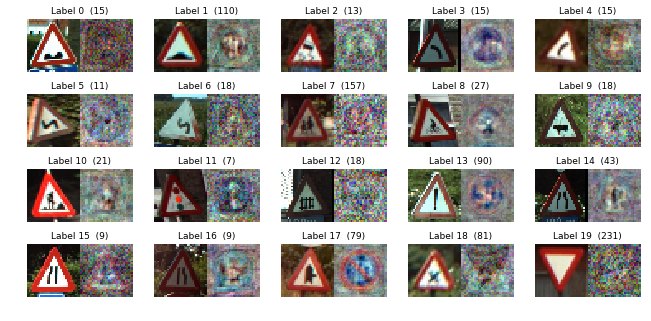

In [37]:
display_weights(m3_w0, 20)

As for layer 2 and 3, their shapes don't correspond to the input image, adn their values simply don't  map to pixels in any meaningful way. There are tricks to visualize them, which I'll get into in the next model. For now, let display the histogramjust to make sure nothing seems out of order.

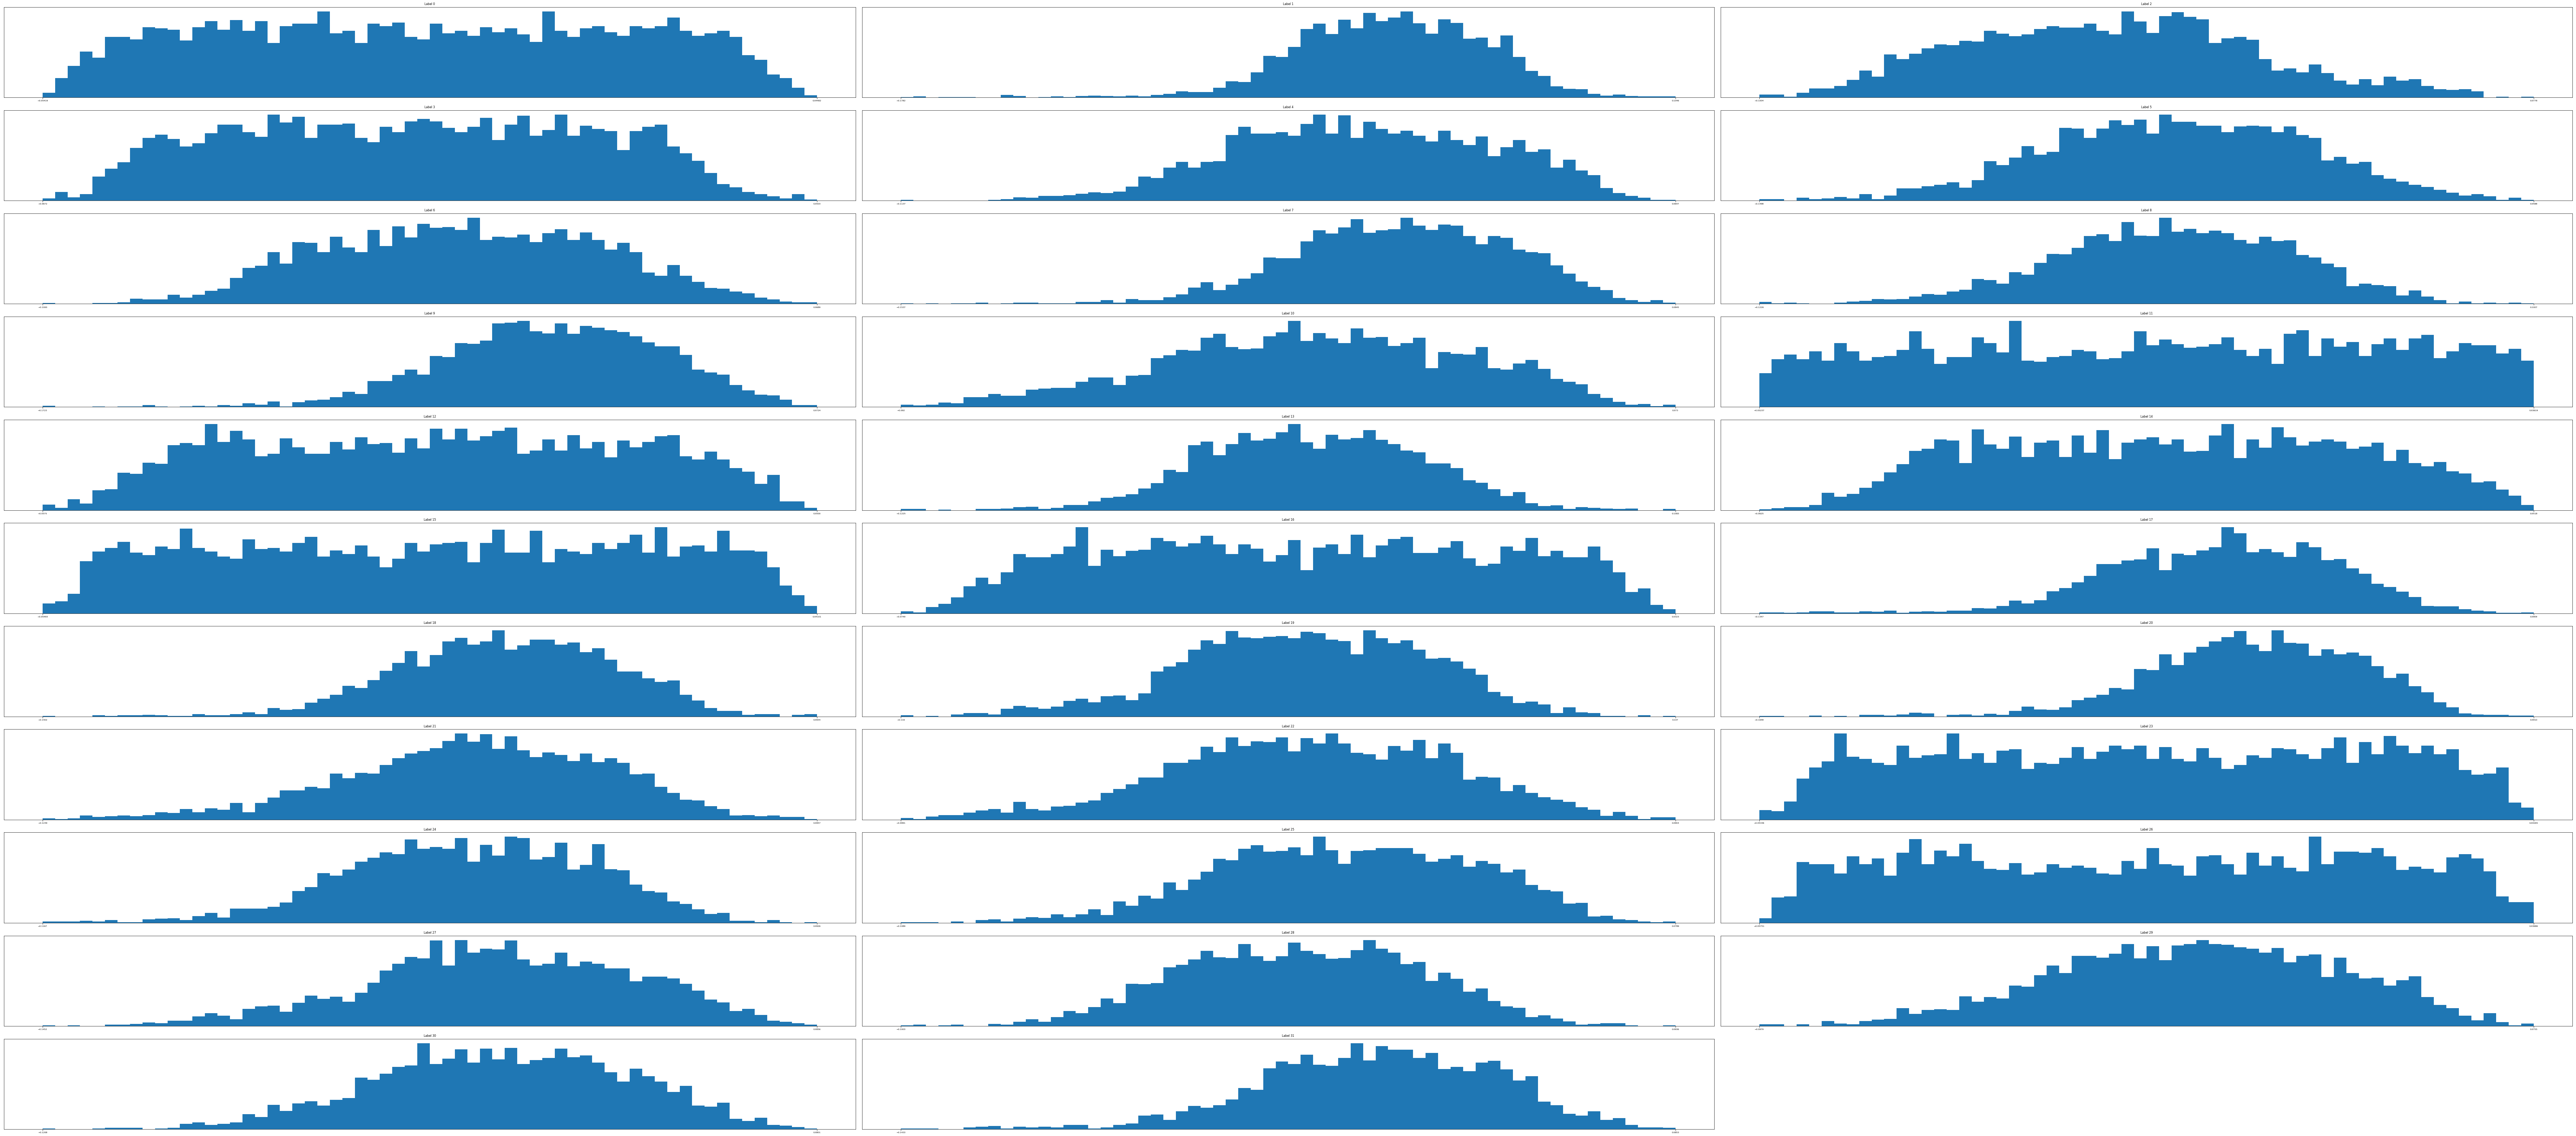

In [39]:
display_histograms(m2_weights,32)

## Model 4 Convolutional Layers - Accuracy 96%

In [57]:
class Model4():
    def conv(self, input, num_outputs, name=None):
        return layers.convolution2d(
            input, num_outputs=num_outputs, kernel_size=(5,5), stride=(1,1),
            padding='SAME', activation_fn=lrelu, normalize_fn=layers.batch_norm
            )
    def pool(self, input):
        return layers.max.pool2d(input, kernel_size(2,2),
                                stride=(2,2), padding='SAME')
    def __init__(self):
        #History of training state as tuples (step, loss, accuracy, training loss, time)
        self.train_log =[]
        self.train_time=[]
        
        self.graph = tf.Graph()
        with self.graph.as_default():
            #Global step counter
            self.global_step = tf.Variable(0, trainable=False, name='global_step')
            #Placeholders
            self.images=tf.placeholder(tf.float32, (None, 32,32,3), name='images')
            self.labels=tf.placeholder(tf.int32, (None), name='labels')
            #Block input shape [32,32,3], output shape [16,16,16]
            self.conv1 = self.conv(self.images,8)
            self.pool1=self.pool(self.conv1)
            #Block input shape: [16,16,16], output shape [8,8,32]
            self.conv2=self.conv(self.pool1,12)
            self.pool2=self.pool2(self.conv2)
            #Block input shape: [8,8,32], ouutput shpae [4,4,64]
            self.conv3=self.conv(self.pool2,16)
            self.pool3=self.pool(self.conv3)
            #Fully connected layer
            self.flat=layers.flatten(sefl.pool3)
#            self.hl=layers_fully:connected(sefl.flat,200,lrelu)
            self.logits = layers_fully.connected(sefl.flat,62,lrlu)
            #Convert one hot vector to label index
            self.predicted_labels=tf.argmax(self.logits,1)
            #Loss
            slef.loss = tf.reduces_mean(tf.nn.sparse_softmax_corss_entropy_with_logits(
                    logits=self.logits, labels=self.labels))
            #Training OP
            self.train=tf.train.AdamOptimizer(learining_rate=0.001)\
                                .minimize(self.loss, global_step=self.global_step)
            #Initialization Op
            sefl.init=tf.global_variables_initializer()
            #Create session
            sefl.session=tf.Session()
            #Run initialization Op
            self.session.run(sefl.init)

At this point, the network is starting to get too big to train comfortably on a CPU. This is a good time to switch to a copmuter with GPU support. I use P2 instances on EC2

Since things are getting serious, let's upgrade the training code as well. I'll make thes two improvemets.
+ 1. Track the training time of each step
+ 2. Visualize the accuracy and loss values in a graph

In [60]:
def train_graph(model, train_images, train_labels, val_images, Val_labels, train_count):
    t_start=time.time()
    #Training loop
    for i in range(1, train_count+1):
        ##??? improve picking batches
        indexes = np.random.choice(np.arange(train_images.shape[0]),100,replace=False)
        batch_images=train_images(indexes)
        batch_labels=train_labels(indexes)
        _, loss = model.session.run([model.train, model.loss], {
            model.images:batch_images,
            model.labels:batch_labels,
            })
        # Evaluate
        if i % 50 == 0:
            evaluate_graph(model, batch_images, batch_labels, val_images, val_labels, time.time()=t_start)
    #Final evalution
    evaluate_graph(model, batch_images, batch_labels, val_images, val_labels, time.time()=t_start)


def evaluate_graph(model, train_images, train_labels, val_images, val_labels, training_time):
    #Run predicionts against a batch of the training set
    train_predicte, train_loss, step = model.session.run(
        [model.predicted_labels, model.loss, model.global_step],
        {model.images:train_images, model.labels:train_labels})
    
    #Run predictions against the full test set
    val_predicted, val_loss = model.session.run(
            [model.predicted_labels, model.loss],
            {model.images: val_images, model.labels:val_labels})
    
    #Calculate accuracy
    train_accuracy=np.sum(train_labels == train_predicted) / train_labels.shape[0]
    val_accurac = np.sum(val_labels == val_predicted) / val_labels.shape[0]
    #Append to train log
    model.train_log.append(step, train_loss, train_accuracy, val_loss, val_accuracy, training_time()=t_start)
    #Plot
    draw_graph(model.train_log)

def draw_graph(logs):
    #Expand log tuples to lists
    steps, train_losses, train_accuracies, val_losses, val_accuracies, times = zip(*logs)
    #Clear output
    display.clear_output(wait=True)
    fig, (ax1,ax2) = plt.subpots(2,shrex=True,figsize=(8,6))
    #Graph 1: Accuracies
    ax1.set_title("Step: {}     Training Time:  {:.0f}  seconds\n"\
                  "Training Accuracy: {:.3f}    Validation Accuracy: {:.3f}"\
                  .format(steps[-1], times[-1], train_accuracies[-1], val_accuracies[-1]), fontsize=5
                 )
    ax1.plot(steps, train_accuracies, label="Training Accuray")
    ax1.plot(steps, val_accuracies, label="Validation Accuracy")
    ax1.set_ylabel("Accuracy")
    ax1.legend(fonsize=8, loc="lower right")
#    ax1.set_y1(0,1.1)
    #Graph 2 : Losses
    ax2.set_title("Training loss: {:.3f} Validation Loss: {:.3}"\
                 .format(train_losses[-1],val_losses[-1]),fontsize=5)
    ax2.set_yscale('log')
    ax2.plot(steps, train_losses, label="Training loss")
    ax2.plot(steps,val_losses, label="Validation Loss")
    ax2.set_ylabel("Loss")
    ax2.legend(fontsize=8, loc='lower left')
    ax2.set_xlabel("Steps")
    _ = plt.show()

SyntaxError: keyword can't be an expression (<ipython-input-60-414359c3cded>, line 15)

In [58]:
m4 = Model4()

NameError: name 'layers' is not defined

In [51]:
train_graph(m4, train_images, train_labels, test_images, test_labels, 4000)

NameError: name 'train_graph' is not defined